# 10 现代轻量级 CNN 架构

> 从深度可分离卷积到 MobileNet 与 EfficientNet

---

**本章重点**：理解如何设计高效的 CNN 架构，以更少的参数和计算量达到相近的性能。

## 📚 学习目标

- [ ] 理解标准卷积的计算瓶颈
- [ ] **深入理解深度可分离卷积（Depthwise Separable Convolution）**
- [ ] **从零实现深度可分离卷积**
- [ ] 理解 MobileNet V1/V2 的核心设计
- [ ] 了解 EfficientNet 的复合缩放思想
- [ ] 在 CIFAR-10 上对比不同架构的效率

## 🔍 前置知识

在开始之前，请确保你已经掌握：

- **02_convolution_math.ipynb** - 卷积的数学原理
- **03_convolution_from_scratch.ipynb** - 卷积的从零实现
- **07_classic_architectures.ipynb** - ResNet 和残差连接

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

---

# Part 1: 为什么需要轻量级架构？

## 1.1 移动端部署的挑战

传统 CNN（如 VGG、ResNet）虽然效果好，但存在以下问题：

| 挑战 | 说明 |
|------|------|
| **内存限制** | 移动设备 RAM 通常只有 2-8 GB，模型参数不能太大 |
| **计算限制** | 移动 GPU/NPU 算力有限，需要减少 FLOPs |
| **延迟要求** | 实时应用需要 <100ms 的推理时间 |
| **能耗限制** | 电池供电，需要高效的计算 |

### 典型架构的资源消耗

```
模型           | 参数量   | FLOPs    | ImageNet Top-1
---------------|----------|----------|---------------
VGG-16         | 138M     | 15.5G    | 71.5%
ResNet-50      | 25.6M    | 4.1G     | 76.1%
MobileNet V2   | 3.5M     | 0.3G     | 72.0%  ← 参数少 7x，计算少 13x！
EfficientNet-B0| 5.3M     | 0.4G     | 77.1%  ← 比 ResNet-50 更准，计算少 10x！
```

## 1.2 FLOPs 与 MACs 计算

### 什么是 FLOPs 和 MACs？

- **FLOPs**（Floating Point Operations）：浮点运算次数
- **MACs**（Multiply-Accumulate Operations）：乘加运算次数
- 关系：FLOPs ≈ 2 × MACs（一次乘加 = 一次乘法 + 一次加法）

### 标准卷积的计算量

对于一个标准卷积层：
- 输入：$(C_{in}, H, W)$
- 卷积核：$(C_{out}, C_{in}, K, K)$
- 输出：$(C_{out}, H', W')$

$$\text{MACs} = C_{out} \times H' \times W' \times C_{in} \times K \times K$$

$$\text{参数量} = C_{out} \times C_{in} \times K \times K + C_{out}$$

In [2]:
def compute_conv_stats(in_channels, out_channels, kernel_size, input_size, stride=1, padding=0):
    """
    计算标准卷积的参数量和 MACs
    
    参数:
        in_channels: 输入通道数 C_in
        out_channels: 输出通道数 C_out
        kernel_size: 卷积核大小 K
        input_size: 输入空间尺寸 (H, W)
        stride: 步幅
        padding: 填充
    
    返回:
        dict: 包含参数量、MACs、输出尺寸
    """
    H, W = input_size
    K = kernel_size
    
    # ========================================
    # 第1步：计算输出尺寸
    # 公式: H_out = (H + 2*padding - K) / stride + 1
    # ========================================
    H_out = (H + 2 * padding - K) // stride + 1
    W_out = (W + 2 * padding - K) // stride + 1
    
    # ========================================
    # 第2步：计算参数量
    # 每个卷积核: C_in × K × K
    # 共 C_out 个卷积核 + C_out 个偏置
    # ========================================
    params = out_channels * in_channels * K * K + out_channels
    
    # ========================================
    # 第3步：计算 MACs
    # 输出的每个位置需要 C_in × K × K 次乘加
    # 共 C_out × H_out × W_out 个输出位置
    # ========================================
    macs = out_channels * H_out * W_out * in_channels * K * K
    
    return {
        'params': params,
        'macs': macs,
        'output_size': (out_channels, H_out, W_out)
    }


# 示例：ResNet 中典型的卷积层
print("标准 3×3 卷积计算量示例")
print("=" * 50)

# 256 通道 → 256 通道，特征图 14×14
stats = compute_conv_stats(
    in_channels=256, 
    out_channels=256, 
    kernel_size=3, 
    input_size=(14, 14),
    padding=1
)

print(f"输入: (256, 14, 14)")
print(f"卷积: 3×3, 256 通道")
print(f"输出: {stats['output_size']}")
print(f"\n参数量: {stats['params']:,} ({stats['params']/1e6:.2f}M)")
print(f"MACs: {stats['macs']:,} ({stats['macs']/1e6:.2f}M)")
print(f"FLOPs ≈ {2*stats['macs']:,} ({2*stats['macs']/1e6:.2f}M)")

标准 3×3 卷积计算量示例
输入: (256, 14, 14)
卷积: 3×3, 256 通道
输出: (256, 14, 14)

参数量: 590,080 (0.59M)
MACs: 115,605,504 (115.61M)
FLOPs ≈ 231,211,008 (231.21M)


---

# Part 2: 深度可分离卷积 ⭐ 核心

## 2.1 核心思想：分解卷积

**标准卷积**同时完成两件事：
1. 空间特征提取（在 H×W 上滑动）
2. 通道特征融合（跨 $C_{in}$ 个通道求和）

**深度可分离卷积**将这两步分开：

```
标准卷积：
    输入 (C_in, H, W) ──→ [Conv K×K] ──→ 输出 (C_out, H', W')
                           ↑
                     同时处理空间和通道

深度可分离卷积：
    输入 (C_in, H, W) ──→ [Depthwise 3×3] ──→ (C_in, H', W') ──→ [Pointwise 1×1] ──→ (C_out, H', W')
                                ↑                                       ↑
                         每个通道单独卷积                        跨通道融合
```

## 2.2 Depthwise 卷积

**核心**：每个输入通道使用一个独立的 K×K 卷积核，不跨通道。

```
输入 (3, 5, 5)：3个通道

Channel 0     Channel 1     Channel 2
┌─────┐       ┌─────┐       ┌─────┐
│█████│       │█████│       │█████│
│█████│  ×    │█████│  ×    │█████│
│█████│       │█████│       │█████│
└─────┘       └─────┘       └─────┘
   ↓             ↓             ↓
Kernel 0     Kernel 1     Kernel 2      ← 每个通道一个独立的 3×3 核
[3×3]        [3×3]        [3×3]
   ↓             ↓             ↓
Output 0     Output 1     Output 2      ← 输出通道数 = 输入通道数
```

**参数量**：$C_{in} \times K \times K$（远小于标准卷积的 $C_{out} \times C_{in} \times K \times K$）

## 2.3 Pointwise 卷积（1×1 卷积）

**核心**：使用 1×1 的卷积核在通道间融合信息。

```
输入 (C_in, H, W)
      ↓
    [1×1 Conv]
      ↓
输出 (C_out, H, W)     ← 改变通道数，不改变空间尺寸
```

**参数量**：$C_{out} \times C_{in} \times 1 \times 1 = C_{out} \times C_{in}$

## 2.4 效率对比：压缩比推导

对于相同的输入输出：$(C_{in}, H, W) \rightarrow (C_{out}, H', W')$

### 标准卷积
- 参数量：$C_{out} \times C_{in} \times K^2$
- MACs：$C_{out} \times H' \times W' \times C_{in} \times K^2$

### 深度可分离卷积
- Depthwise 参数：$C_{in} \times K^2$
- Pointwise 参数：$C_{out} \times C_{in}$
- 总参数：$C_{in} \times K^2 + C_{out} \times C_{in}$

### 压缩比

$$\text{压缩比} = \frac{C_{in} \times K^2 + C_{out} \times C_{in}}{C_{out} \times C_{in} \times K^2} = \frac{1}{C_{out}} + \frac{1}{K^2}$$

当 $C_{out}$ 很大（如 256）且 $K=3$ 时：

$$\text{压缩比} \approx \frac{1}{256} + \frac{1}{9} \approx 0.115 \approx \frac{1}{9}$$

**参数量和计算量都减少约 9 倍！**

In [3]:
def compute_separable_conv_stats(in_channels, out_channels, kernel_size, input_size, stride=1, padding=0):
    """
    计算深度可分离卷积的参数量和 MACs
    
    深度可分离卷积 = Depthwise + Pointwise
    """
    H, W = input_size
    K = kernel_size
    
    # 输出尺寸（由 Depthwise 决定）
    H_out = (H + 2 * padding - K) // stride + 1
    W_out = (W + 2 * padding - K) // stride + 1
    
    # ========================================
    # Depthwise 卷积
    # 每个输入通道一个 K×K 的核
    # ========================================
    dw_params = in_channels * K * K
    dw_macs = in_channels * H_out * W_out * K * K
    
    # ========================================
    # Pointwise 卷积（1×1）
    # C_out 个 1×1×C_in 的核
    # ========================================
    pw_params = out_channels * in_channels * 1 * 1
    pw_macs = out_channels * H_out * W_out * in_channels
    
    return {
        'dw_params': dw_params,
        'pw_params': pw_params,
        'total_params': dw_params + pw_params,
        'dw_macs': dw_macs,
        'pw_macs': pw_macs,
        'total_macs': dw_macs + pw_macs,
        'output_size': (out_channels, H_out, W_out)
    }


# 对比：标准卷积 vs 深度可分离卷积
print("标准卷积 vs 深度可分离卷积")
print("=" * 60)

in_ch, out_ch = 256, 256
input_size = (14, 14)

std_stats = compute_conv_stats(in_ch, out_ch, 3, input_size, padding=1)
sep_stats = compute_separable_conv_stats(in_ch, out_ch, 3, input_size, padding=1)

print(f"\n输入: ({in_ch}, {input_size[0]}, {input_size[1]})")
print(f"输出: {std_stats['output_size']}")

print(f"\n{'指标':<15} {'标准卷积':>15} {'深度可分离':>15} {'压缩比':>10}")
print("-" * 55)
print(f"{'参数量':<15} {std_stats['params']:>15,} {sep_stats['total_params']:>15,} {std_stats['params']/sep_stats['total_params']:>10.1f}x")
print(f"{'MACs':<15} {std_stats['macs']:>15,} {sep_stats['total_macs']:>15,} {std_stats['macs']/sep_stats['total_macs']:>10.1f}x")

print(f"\n深度可分离卷积分解：")
print(f"  Depthwise: {sep_stats['dw_params']:,} 参数, {sep_stats['dw_macs']:,} MACs")
print(f"  Pointwise: {sep_stats['pw_params']:,} 参数, {sep_stats['pw_macs']:,} MACs")

标准卷积 vs 深度可分离卷积

输入: (256, 14, 14)
输出: (256, 14, 14)

指标                         标准卷积           深度可分离        压缩比
-------------------------------------------------------
参数量                     590,080          67,840        8.7x
MACs                115,605,504      13,296,640        8.7x

深度可分离卷积分解：
  Depthwise: 2,304 参数, 451,584 MACs
  Pointwise: 65,536 参数, 12,845,056 MACs


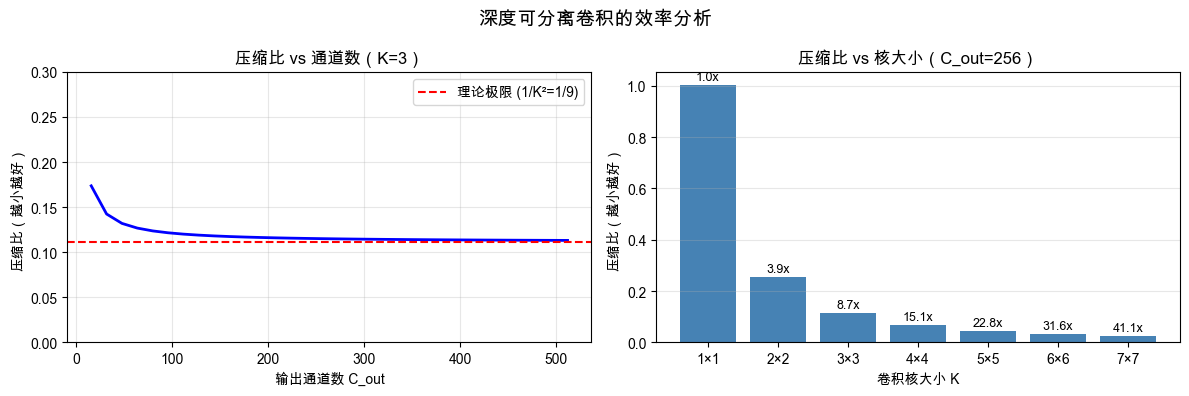

💡 关键发现：
   - 通道数越多，压缩比越接近理论极限 1/K²
   - 3×3 卷积可以获得约 9 倍压缩
   - 5×5 卷积可以获得约 25 倍压缩


In [4]:
# 可视化：压缩比随通道数和核大小变化

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1. 压缩比 vs 输出通道数（固定 K=3）
channels = np.arange(16, 513, 16)
K = 3
compression = 1/channels + 1/(K**2)

axes[0].plot(channels, compression, 'b-', linewidth=2)
axes[0].axhline(y=1/9, color='r', linestyle='--', label=f'理论极限 (1/K²=1/{K**2})')
axes[0].set_xlabel('输出通道数 C_out')
axes[0].set_ylabel('压缩比（越小越好）')
axes[0].set_title('压缩比 vs 通道数（K=3）')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 0.3)

# 2. 压缩比 vs 核大小（固定 C_out=256）
kernel_sizes = np.arange(1, 8)
C_out = 256
compression_k = 1/C_out + 1/(kernel_sizes**2)

axes[1].bar(kernel_sizes, compression_k, color='steelblue')
axes[1].set_xlabel('卷积核大小 K')
axes[1].set_ylabel('压缩比（越小越好）')
axes[1].set_title('压缩比 vs 核大小（C_out=256）')
axes[1].set_xticks(kernel_sizes)
axes[1].set_xticklabels([f'{k}×{k}' for k in kernel_sizes])
axes[1].grid(True, alpha=0.3, axis='y')

# 标注数值
for i, (k, c) in enumerate(zip(kernel_sizes, compression_k)):
    axes[1].text(k, c + 0.02, f'{1/c:.1f}x', ha='center', fontsize=9)

plt.suptitle('深度可分离卷积的效率分析', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 关键发现：")
print("   - 通道数越多，压缩比越接近理论极限 1/K²")
print("   - 3×3 卷积可以获得约 9 倍压缩")
print("   - 5×5 卷积可以获得约 25 倍压缩")

---

## 2.5 从零实现深度可分离卷积（NumPy）

### Depthwise 卷积的实现

In [5]:
def depthwise_conv2d(input_tensor, kernels, stride=1, padding=0):
    """
    深度卷积的从零实现（NumPy 版本）
    
    核心思想：每个输入通道使用一个独立的卷积核，不跨通道
    
    参数:
        input_tensor: 输入张量, shape (C, H, W)
        kernels: 卷积核, shape (C, K, K)  ← 注意：每个通道一个核
        stride: 步幅
        padding: 填充
    
    返回:
        output: 输出张量, shape (C, H_out, W_out)
    """
    # ========================================
    # 第1步：获取输入和核的形状
    # ========================================
    C, H, W = input_tensor.shape
    C_k, K, _ = kernels.shape
    
    assert C == C_k, "卷积核数量必须等于输入通道数"
    
    # ========================================
    # 第2步：添加 padding
    # ========================================
    if padding > 0:
        # 只在 H 和 W 维度填充
        input_padded = np.pad(
            input_tensor,
            pad_width=((0, 0), (padding, padding), (padding, padding)),
            mode='constant',
            constant_values=0
        )
    else:
        input_padded = input_tensor
    
    # ========================================
    # 第3步：计算输出尺寸
    # ========================================
    H_padded, W_padded = input_padded.shape[1], input_padded.shape[2]
    H_out = (H_padded - K) // stride + 1
    W_out = (W_padded - K) // stride + 1
    
    # ========================================
    # 第4步：初始化输出
    # 输出通道数 = 输入通道数（这是 Depthwise 的特点）
    # ========================================
    output = np.zeros((C, H_out, W_out))
    
    # ========================================
    # 第5步：对每个通道独立进行卷积
    # 这是 Depthwise 的核心：不跨通道！
    # ========================================
    for c in range(C):
        # 取出当前通道的输入和对应的卷积核
        channel_input = input_padded[c]  # shape: (H_padded, W_padded)
        kernel = kernels[c]               # shape: (K, K)
        
        # 在当前通道上进行 2D 卷积
        for i in range(H_out):
            for j in range(W_out):
                # 提取感受野区域
                h_start = i * stride
                w_start = j * stride
                region = channel_input[h_start:h_start+K, w_start:w_start+K]
                
                # 点积计算
                output[c, i, j] = np.sum(region * kernel)
    
    return output


# 测试 Depthwise 卷积
print("Depthwise 卷积测试")
print("=" * 50)

# 创建测试输入：3 通道，5×5 的图像
np.random.seed(42)
test_input = np.random.randn(3, 5, 5)

# 创建 3 个独立的 3×3 卷积核（每个通道一个）
test_kernels = np.random.randn(3, 3, 3)

# 执行 Depthwise 卷积
dw_output = depthwise_conv2d(test_input, test_kernels, padding=1)

print(f"输入形状: {test_input.shape}")
print(f"卷积核形状: {test_kernels.shape}")
print(f"输出形状: {dw_output.shape}")
print(f"\n✓ 输出通道数 = 输入通道数 = {dw_output.shape[0]}（Depthwise 特点）")

Depthwise 卷积测试
输入形状: (3, 5, 5)
卷积核形状: (3, 3, 3)
输出形状: (3, 5, 5)

✓ 输出通道数 = 输入通道数 = 3（Depthwise 特点）


### Pointwise 卷积的实现

In [6]:
def pointwise_conv2d(input_tensor, kernels):
    """
    点卷积（1×1 卷积）的从零实现
    
    核心思想：在每个空间位置上，对所有通道进行线性组合
    
    参数:
        input_tensor: 输入张量, shape (C_in, H, W)
        kernels: 1×1 卷积核, shape (C_out, C_in)
    
    返回:
        output: 输出张量, shape (C_out, H, W)
    
    数学等价于:
        对于每个位置 (i, j):
        output[:, i, j] = kernels @ input[:, i, j]
    """
    C_in, H, W = input_tensor.shape
    C_out, C_in_k = kernels.shape
    
    assert C_in == C_in_k, "卷积核输入通道数必须匹配"
    
    # ========================================
    # 方法1：逐位置计算（直观但慢）
    # ========================================
    # output = np.zeros((C_out, H, W))
    # for i in range(H):
    #     for j in range(W):
    #         pixel_vector = input_tensor[:, i, j]  # (C_in,)
    #         output[:, i, j] = kernels @ pixel_vector  # (C_out,)
    
    # ========================================
    # 方法2：向量化计算（高效）
    # 将空间维度展平，用矩阵乘法一次完成
    # ========================================
    # 重塑输入: (C_in, H, W) → (C_in, H*W)
    input_flat = input_tensor.reshape(C_in, -1)
    
    # 矩阵乘法: (C_out, C_in) × (C_in, H*W) → (C_out, H*W)
    output_flat = kernels @ input_flat
    
    # 重塑回原来的空间维度: (C_out, H*W) → (C_out, H, W)
    output = output_flat.reshape(C_out, H, W)
    
    return output


# 测试 Pointwise 卷积
print("Pointwise 卷积测试")
print("=" * 50)

# 输入：3 通道，5×5
test_input = np.random.randn(3, 5, 5)

# 1×1 卷积核：输出 8 通道
test_kernels_1x1 = np.random.randn(8, 3)

# 执行 Pointwise 卷积
pw_output = pointwise_conv2d(test_input, test_kernels_1x1)

print(f"输入形状: {test_input.shape}")
print(f"1×1 卷积核形状: {test_kernels_1x1.shape}")
print(f"输出形状: {pw_output.shape}")
print(f"\n✓ 空间尺寸不变，通道数从 {test_input.shape[0]} 变为 {pw_output.shape[0]}")

Pointwise 卷积测试
输入形状: (3, 5, 5)
1×1 卷积核形状: (8, 3)
输出形状: (8, 5, 5)

✓ 空间尺寸不变，通道数从 3 变为 8


### 完整的深度可分离卷积

In [7]:
def separable_conv2d(input_tensor, dw_kernels, pw_kernels, stride=1, padding=0):
    """
    完整的深度可分离卷积 = Depthwise + Pointwise
    
    参数:
        input_tensor: 输入, shape (C_in, H, W)
        dw_kernels: Depthwise 卷积核, shape (C_in, K, K)
        pw_kernels: Pointwise 卷积核, shape (C_out, C_in)
        stride: 步幅（仅用于 Depthwise）
        padding: 填充（仅用于 Depthwise）
    
    返回:
        output: 输出, shape (C_out, H_out, W_out)
    """
    # ========================================
    # 第1步：Depthwise 卷积
    # 提取空间特征，每个通道独立
    # ========================================
    dw_output = depthwise_conv2d(input_tensor, dw_kernels, stride, padding)
    
    # ========================================
    # 第2步：Pointwise 卷积
    # 跨通道融合，改变通道数
    # ========================================
    output = pointwise_conv2d(dw_output, pw_kernels)
    
    return output


# 测试完整的深度可分离卷积
print("完整深度可分离卷积测试")
print("=" * 50)

# 输入：32 通道，14×14（模拟中间特征图）
np.random.seed(42)
test_input = np.random.randn(32, 14, 14)

# Depthwise 核：每个通道一个 3×3
dw_kernels = np.random.randn(32, 3, 3) * 0.1

# Pointwise 核：32 → 64 通道
pw_kernels = np.random.randn(64, 32) * 0.1

# 执行深度可分离卷积
sep_output = separable_conv2d(test_input, dw_kernels, pw_kernels, padding=1)

print(f"输入形状: {test_input.shape}")
print(f"Depthwise 核: {dw_kernels.shape}")
print(f"Pointwise 核: {pw_kernels.shape}")
print(f"输出形状: {sep_output.shape}")

# 计算参数量对比
std_params = 64 * 32 * 3 * 3
sep_params = 32 * 3 * 3 + 64 * 32
print(f"\n参数量对比：")
print(f"  标准 3×3 卷积: {std_params:,}")
print(f"  深度可分离: {sep_params:,}")
print(f"  压缩比: {std_params / sep_params:.1f}x")

完整深度可分离卷积测试
输入形状: (32, 14, 14)
Depthwise 核: (32, 3, 3)
Pointwise 核: (64, 32)
输出形状: (64, 14, 14)

参数量对比：
  标准 3×3 卷积: 18,432
  深度可分离: 2,336
  压缩比: 7.9x


## 2.6 PyTorch 实现

PyTorch 中通过 `groups` 参数实现 Depthwise 卷积。

In [8]:
class DepthwiseSeparableConv(nn.Module):
    """
    深度可分离卷积的 PyTorch 实现
    
    参数:
        in_channels: 输入通道数
        out_channels: 输出通道数
        kernel_size: 卷积核大小
        stride: 步幅
        padding: 填充
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        # ========================================
        # Depthwise 卷积
        # 关键参数：groups=in_channels
        # 这意味着每个输入通道有自己独立的卷积核
        # ========================================
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,  # 输出通道 = 输入通道
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,  # 关键！每个通道独立
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # ========================================
        # Pointwise 卷积（1×1）
        # ========================================
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        # Depthwise
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Pointwise
        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        return x


# 对比参数量
print("PyTorch 实现对比")
print("=" * 50)

in_ch, out_ch = 64, 128

# 标准卷积
std_conv = nn.Sequential(
    nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
    nn.BatchNorm2d(out_ch),
    nn.ReLU()
)

# 深度可分离卷积
sep_conv = DepthwiseSeparableConv(in_ch, out_ch)

std_params = sum(p.numel() for p in std_conv.parameters())
sep_params = sum(p.numel() for p in sep_conv.parameters())

print(f"标准卷积参数量: {std_params:,}")
print(f"深度可分离参数量: {sep_params:,}")
print(f"压缩比: {std_params / sep_params:.2f}x")

# 测试前向传播
x = torch.randn(1, in_ch, 32, 32)
y_std = std_conv(x)
y_sep = sep_conv(x)
print(f"\n输入: {x.shape}")
print(f"标准卷积输出: {y_std.shape}")
print(f"深度可分离输出: {y_sep.shape}")

PyTorch 实现对比
标准卷积参数量: 73,984
深度可分离参数量: 9,152
压缩比: 8.08x

输入: torch.Size([1, 64, 32, 32])
标准卷积输出: torch.Size([1, 128, 32, 32])
深度可分离输出: torch.Size([1, 128, 32, 32])


In [9]:
# 验证 NumPy 实现与 PyTorch 实现的一致性
print("验证 NumPy 与 PyTorch 实现一致性")
print("=" * 50)

# 创建相同的输入
np.random.seed(42)
torch.manual_seed(42)

input_np = np.random.randn(3, 5, 5).astype(np.float32)
input_torch = torch.from_numpy(input_np).unsqueeze(0)  # 添加 batch 维度

# 创建 PyTorch Depthwise 卷积层
dw_conv_torch = nn.Conv2d(3, 3, 3, padding=1, groups=3, bias=False)

# 提取 PyTorch 权重用于 NumPy
# PyTorch 权重形状: (out_channels, in_channels/groups, K, K) = (3, 1, 3, 3)
# NumPy 需要的形状: (C, K, K) = (3, 3, 3)
weights_torch = dw_conv_torch.weight.detach().numpy()
weights_np = weights_torch.squeeze(1)  # (3, 1, 3, 3) → (3, 3, 3)

# 使用 NumPy 实现
output_np = depthwise_conv2d(input_np, weights_np, padding=1)

# 使用 PyTorch
with torch.no_grad():
    output_torch = dw_conv_torch(input_torch).squeeze(0).numpy()

# 比较结果
diff = np.abs(output_np - output_torch).max()
print(f"最大差异: {diff:.2e}")
print(f"是否一致: {'✓' if diff < 1e-5 else '✗'}")

验证 NumPy 与 PyTorch 实现一致性
最大差异: 2.38e-07
是否一致: ✓


---

# Part 3: MobileNet 系列

## 3.1 MobileNet V1

MobileNet V1 (2017) 是第一个将深度可分离卷积系统性应用于移动端的架构。

### 核心设计

1. **基础块**：Depthwise 3×3 → BN → ReLU → Pointwise 1×1 → BN → ReLU
2. **宽度乘数 α**：控制每层的通道数，$C' = \alpha \times C$
3. **分辨率乘数 ρ**：控制输入分辨率，$R' = \rho \times R$

In [10]:
class MobileNetV1Block(nn.Module):
    """
    MobileNet V1 的基础块
    
    结构：Depthwise 3×3 → BN → ReLU → Pointwise 1×1 → BN → ReLU
    """
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # Depthwise 卷积
        self.depthwise = nn.Conv2d(
            in_channels, in_channels,
            kernel_size=3, stride=stride, padding=1,
            groups=in_channels, bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        
        # Pointwise 卷积
        self.pointwise = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.depthwise(x)))
        x = F.relu(self.bn2(self.pointwise(x)))
        return x


# 测试 MobileNet V1 块
block = MobileNetV1Block(32, 64, stride=2)
x = torch.randn(1, 32, 16, 16)
y = block(x)
print(f"MobileNet V1 Block:")
print(f"  输入: {x.shape}")
print(f"  输出: {y.shape}")
print(f"  参数量: {sum(p.numel() for p in block.parameters()):,}")

MobileNet V1 Block:
  输入: torch.Size([1, 32, 16, 16])
  输出: torch.Size([1, 64, 8, 8])
  参数量: 2,528


## 3.2 MobileNet V2：倒残差结构

MobileNet V2 (2018) 引入了**倒残差结构（Inverted Residual）**，也称为 **MBConv**。

### 对比：传统残差 vs 倒残差

```
传统残差块（ResNet）：              倒残差块（MobileNet V2）：

输入 (256 通道)                    输入 (24 通道)
    ↓                                  ↓
Conv 1×1 降维 → 64                 Conv 1×1 升维 → 144 (×6 扩展)
    ↓                                  ↓
Conv 3×3 提特征                    Depthwise 3×3
    ↓                                  ↓
Conv 1×1 升维 → 256                Conv 1×1 降维 → 24
    ↓                                  ↓
  (+) ← 残差连接                     (+) ← 残差连接

「宽 → 窄 → 宽」                   「窄 → 宽 → 窄」
```

### 为什么要倒过来？

1. **信息容量**：低维特征压缩太多会损失信息，在高维空间做卷积更好
2. **ReLU 问题**：ReLU 在低维空间会损失信息（负值变 0），所以最后一层用**线性激活**
3. **效率**：Depthwise 卷积在高维空间效率高（计算量与通道数成正比，但参数不增加）

In [11]:
class InvertedResidual(nn.Module):
    """
    MobileNet V2 的倒残差块（Inverted Residual / MBConv）
    
    结构：
        输入 (C_in)
          ↓
        Expand: Conv 1×1 → (C_in × expand_ratio) → BN → ReLU6
          ↓
        Depthwise: Conv 3×3 → BN → ReLU6
          ↓
        Project: Conv 1×1 → (C_out) → BN (无激活！)
          ↓
        (+) ← 残差连接（仅当 stride=1 且 C_in=C_out）
    
    参数:
        in_channels: 输入通道数
        out_channels: 输出通道数
        stride: 步幅（1 或 2）
        expand_ratio: 扩展比例（通常为 6）
    """
    
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super().__init__()
        
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)
        
        # 扩展后的通道数
        hidden_dim = in_channels * expand_ratio
        
        layers = []
        
        # ========================================
        # Expand 层（当 expand_ratio > 1 时）
        # 使用 1×1 卷积扩展通道数
        # ========================================
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)  # ReLU6: min(max(0, x), 6)
            ])
        
        # ========================================
        # Depthwise 卷积
        # 在高维空间提取空间特征
        # ========================================
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, 
                      groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])
        
        # ========================================
        # Project 层（线性投影，无激活！）
        # 压缩回低维空间
        # ========================================
        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
            # 注意：这里没有激活函数！
        ])
        
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)


# 测试倒残差块
print("倒残差块测试")
print("=" * 50)

# 有残差连接的情况
block1 = InvertedResidual(24, 24, stride=1, expand_ratio=6)
x1 = torch.randn(1, 24, 16, 16)
y1 = block1(x1)
print(f"有残差 (stride=1, in=out=24):")
print(f"  输入: {x1.shape} → 输出: {y1.shape}")
print(f"  参数量: {sum(p.numel() for p in block1.parameters()):,}")

# 无残差连接的情况（下采样）
block2 = InvertedResidual(24, 48, stride=2, expand_ratio=6)
y2 = block2(x1)
print(f"\n无残差 (stride=2, 24→48):")
print(f"  输入: {x1.shape} → 输出: {y2.shape}")
print(f"  参数量: {sum(p.numel() for p in block2.parameters()):,}")

倒残差块测试
有残差 (stride=1, in=out=24):
  输入: torch.Size([1, 24, 16, 16]) → 输出: torch.Size([1, 24, 16, 16])
  参数量: 8,832

无残差 (stride=2, 24→48):
  输入: torch.Size([1, 24, 16, 16]) → 输出: torch.Size([1, 48, 8, 8])
  参数量: 12,336


## 3.3 ReLU6 与量化

MobileNet V2 使用 **ReLU6** 而不是普通 ReLU：

$$\text{ReLU6}(x) = \min(\max(0, x), 6)$$

### 为什么使用 ReLU6？

1. **量化友好**：将输出限制在 [0, 6]，更容易量化为低精度（如 INT8）
2. **数值稳定**：避免激活值过大导致的精度问题
3. **实践验证**：实验表明对准确率影响很小

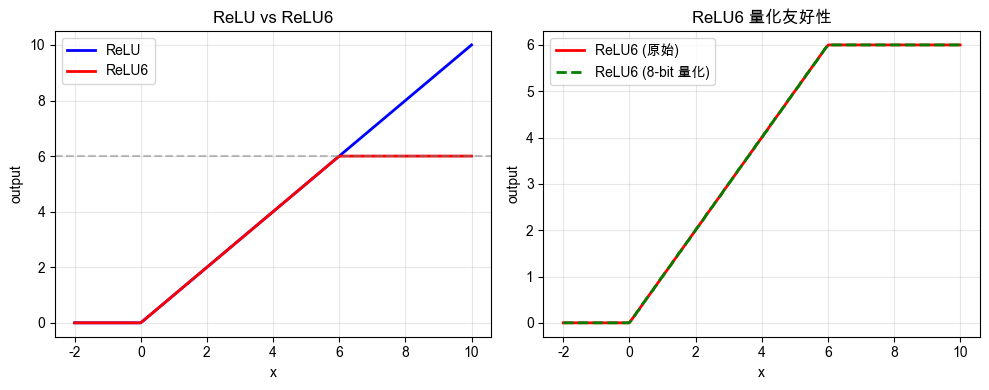

💡 ReLU6 的优势：
   - 输出范围固定 [0, 6]，便于量化
   - 8-bit 量化：[0, 6] → [0, 255]，精度损失很小
   - 对模型准确率影响极小


In [12]:
# 可视化 ReLU vs ReLU6

x = np.linspace(-2, 10, 200)
relu = np.maximum(0, x)
relu6 = np.minimum(np.maximum(0, x), 6)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, relu, 'b-', label='ReLU', linewidth=2)
plt.plot(x, relu6, 'r-', label='ReLU6', linewidth=2)
plt.axhline(y=6, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('x')
plt.ylabel('output')
plt.title('ReLU vs ReLU6')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# 量化示意
quantized = np.round(relu6 * 255 / 6) / 255 * 6  # 模拟 8-bit 量化
plt.plot(x, relu6, 'r-', label='ReLU6 (原始)', linewidth=2)
plt.plot(x, quantized, 'g--', label='ReLU6 (8-bit 量化)', linewidth=2)
plt.xlabel('x')
plt.ylabel('output')
plt.title('ReLU6 量化友好性')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 ReLU6 的优势：")
print("   - 输出范围固定 [0, 6]，便于量化")
print("   - 8-bit 量化：[0, 6] → [0, 255]，精度损失很小")
print("   - 对模型准确率影响极小")

---

# Part 4: EfficientNet 概念

## 4.1 复合缩放思想

EfficientNet (2019) 的核心创新：**复合缩放（Compound Scaling）**

### 问题：如何高效地扩展网络？

传统方法只调整一个维度：
- **宽度**：增加每层的通道数
- **深度**：增加网络层数
- **分辨率**：使用更大的输入图像

### EfficientNet 的方案：同时调整三个维度

$$\text{depth: } d = \alpha^\phi$$
$$\text{width: } w = \beta^\phi$$
$$\text{resolution: } r = \gamma^\phi$$

约束条件：
$$\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$$

这保证了当 $\phi$ 增加 1 时，FLOPs 大约翻倍。

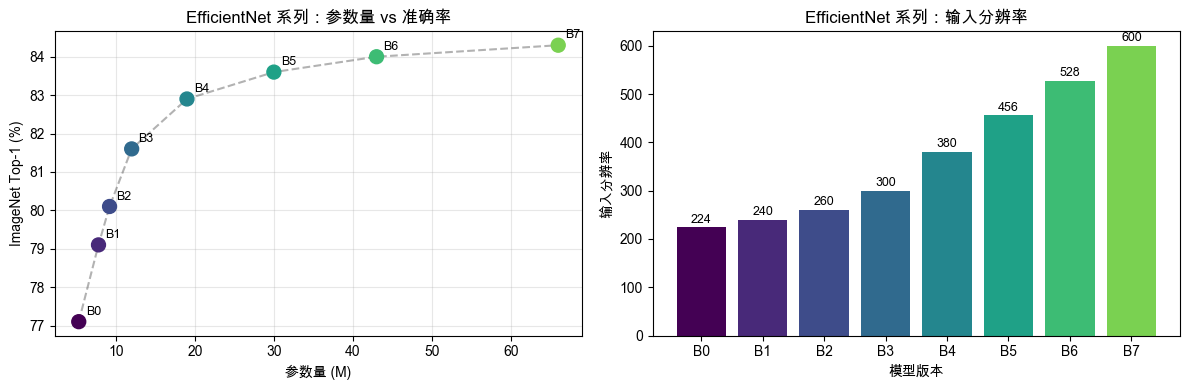

EfficientNet 系列配置：
Model        Params      Top-1   Resolution
------------------------------------------
B0              5.3M      77.1%          224
B1              7.8M      79.1%          240
B2              9.2M      80.1%          260
B3               12M      81.6%          300
B4               19M      82.9%          380
B5               30M      83.6%          456
B6               43M      84.0%          528
B7               66M      84.3%          600


In [13]:
# EfficientNet 系列配置
efficientnet_configs = {
    'B0': {'phi': 0, 'resolution': 224, 'params': 5.3, 'top1': 77.1},
    'B1': {'phi': 0.5, 'resolution': 240, 'params': 7.8, 'top1': 79.1},
    'B2': {'phi': 1, 'resolution': 260, 'params': 9.2, 'top1': 80.1},
    'B3': {'phi': 1.5, 'resolution': 300, 'params': 12, 'top1': 81.6},
    'B4': {'phi': 2, 'resolution': 380, 'params': 19, 'top1': 82.9},
    'B5': {'phi': 2.5, 'resolution': 456, 'params': 30, 'top1': 83.6},
    'B6': {'phi': 3, 'resolution': 528, 'params': 43, 'top1': 84.0},
    'B7': {'phi': 3.5, 'resolution': 600, 'params': 66, 'top1': 84.3},
}

# 可视化 EfficientNet 系列
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

names = list(efficientnet_configs.keys())
params = [efficientnet_configs[n]['params'] for n in names]
top1 = [efficientnet_configs[n]['top1'] for n in names]
resolutions = [efficientnet_configs[n]['resolution'] for n in names]

# 参数量 vs 准确率
colors = plt.cm.viridis(np.linspace(0, 0.8, len(names)))
axes[0].scatter(params, top1, c=colors, s=100, zorder=5)
for i, name in enumerate(names):
    axes[0].annotate(name, (params[i], top1[i]), textcoords="offset points", 
                     xytext=(5, 5), fontsize=9)
axes[0].plot(params, top1, 'k--', alpha=0.3)
axes[0].set_xlabel('参数量 (M)')
axes[0].set_ylabel('ImageNet Top-1 (%)')
axes[0].set_title('EfficientNet 系列：参数量 vs 准确率')
axes[0].grid(True, alpha=0.3)

# 分辨率变化
axes[1].bar(names, resolutions, color=colors)
axes[1].set_xlabel('模型版本')
axes[1].set_ylabel('输入分辨率')
axes[1].set_title('EfficientNet 系列：输入分辨率')
for i, (n, r) in enumerate(zip(names, resolutions)):
    axes[1].text(i, r + 10, f'{r}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("EfficientNet 系列配置：")
print(f"{'Model':<8} {'Params':>10} {'Top-1':>10} {'Resolution':>12}")
print("-" * 42)
for name, cfg in efficientnet_configs.items():
    print(f"{name:<8} {cfg['params']:>10}M {cfg['top1']:>9.1f}% {cfg['resolution']:>12}")

## 4.2 MBConv 块

EfficientNet 的基础块是 **MBConv**（Mobile Inverted Bottleneck Convolution），在 MobileNet V2 的倒残差块基础上添加了 **Squeeze-and-Excitation (SE)** 注意力模块。

```
输入 (C_in)
    ↓
Expand: Conv 1×1 → (C_in × t) → BN → Swish
    ↓
Depthwise: Conv K×K → BN → Swish
    ↓
SE: Squeeze-and-Excitation (可选)
    ↓
Project: Conv 1×1 → (C_out) → BN
    ↓
(+) ← 残差连接 + Stochastic Depth
```

## 4.3 使用预训练 EfficientNet

In [14]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# 加载预训练的 EfficientNet-B0
print("加载 EfficientNet-B0...")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model.eval()

# 统计信息
total_params = sum(p.numel() for p in model.parameters())
print(f"参数量: {total_params:,} ({total_params/1e6:.1f}M)")

# 测试推理
x = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    y = model(x)
print(f"输入: {x.shape}")
print(f"输出: {y.shape}")
print(f"预测类别: {y.argmax().item()}")

加载 EfficientNet-B0...
参数量: 5,288,548 (5.3M)
输入: torch.Size([1, 3, 224, 224])
输出: torch.Size([1, 1000])
预测类别: 21


---

# Part 5: 实战对比

在 CIFAR-10 上对比三种架构的效率和性能。

In [15]:
# 定义三种网络用于 CIFAR-10

class SimpleCNN(nn.Module):
    """简单 CNN（使用标准卷积）"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


class MobileNetV2_Small(nn.Module):
    """简化版 MobileNet V2（用于 CIFAR-10）"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # 初始层
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )
        
        # 倒残差块
        # (in_channels, out_channels, stride, expand_ratio)
        self.blocks = nn.Sequential(
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 1, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),  # 下采样
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),  # 下采样
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6), # 下采样
            InvertedResidual(160, 320, 1, 6),
        )
        
        # 最后的 1×1 卷积
        self.last_conv = nn.Sequential(
            nn.Conv2d(320, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.last_conv(x)
        return self.classifier(x)


# 创建模型并统计参数
models_dict = {
    'SimpleCNN': SimpleCNN(),
    'MobileNetV2_Small': MobileNetV2_Small(),
}

print("模型参数量对比")
print("=" * 40)
for name, model in models_dict.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"{name:<20} {params:>12,} ({params/1e6:.2f}M)")

模型参数量对比
SimpleCNN               1,130,378 (1.13M)
MobileNetV2_Small       1,236,746 (1.24M)


In [ ]:
# 加载 CIFAR-10 数据集
print("加载 CIFAR-10 数据集...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

print(f"训练集: {len(train_data)} 样本")
print(f"测试集: {len(test_data)} 样本")

In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01):
    """
    训练模型并返回历史记录
    
    参数:
        model: PyTorch 模型
        train_loader: 训练数据加载器
        test_loader: 测试数据加载器
        epochs: 训练轮数
        lr: 学习率
    
    返回:
        history: 包含训练和测试准确率的字典
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_acc': [], 'test_acc': [], 'train_time': []}
    
    for epoch in range(epochs):
        # 训练
        model.train()
        correct, total = 0, 0
        start_time = time.time()
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        
        train_time = time.time() - start_time
        train_acc = 100 * correct / total
        
        # 测试
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        test_acc = 100 * correct / total
        
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_time'].append(train_time)
        
        print(f"Epoch {epoch+1}/{epochs}: Train={train_acc:.1f}%, Test={test_acc:.1f}%, Time={train_time:.1f}s")
        
        scheduler.step()
    
    return history


# 训练对比（使用较少的 epoch 快速演示）
EPOCHS = 5

results = {}
for name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"训练 {name}")
    print(f"{'='*50}")
    results[name] = train_model(model, train_loader, test_loader, epochs=EPOCHS)

In [ ]:
# 可视化结果

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = {'SimpleCNN': 'steelblue', 'MobileNetV2_Small': 'coral'}

# 1. 测试准确率曲线
for name, history in results.items():
    axes[0].plot(range(1, EPOCHS+1), history['test_acc'], 
                 label=name, color=colors[name], linewidth=2, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('测试准确率')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 参数量对比
names = list(results.keys())
params = [sum(p.numel() for p in models_dict[n].parameters()) / 1e6 for n in names]
bars = axes[1].bar(names, params, color=[colors[n] for n in names])
axes[1].set_ylabel('参数量 (M)')
axes[1].set_title('模型大小')
for bar, p in zip(bars, params):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                 f'{p:.2f}M', ha='center', fontsize=10)

# 3. 训练时间对比
avg_times = [np.mean(results[n]['train_time']) for n in names]
bars = axes[2].bar(names, avg_times, color=[colors[n] for n in names])
axes[2].set_ylabel('平均 Epoch 时间 (s)')
axes[2].set_title('训练速度')
for bar, t in zip(bars, avg_times):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{t:.1f}s', ha='center', fontsize=10)

plt.suptitle('架构对比：SimpleCNN vs MobileNetV2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 总结
print("\n" + "=" * 60)
print("实验总结")
print("=" * 60)
print(f"\n{'模型':<20} {'参数量':>12} {'最终准确率':>12} {'Epoch时间':>12}")
print("-" * 56)
for name in names:
    p = sum(p.numel() for p in models_dict[name].parameters())
    acc = results[name]['test_acc'][-1]
    t = np.mean(results[name]['train_time'])
    print(f"{name:<20} {p/1e6:>11.2f}M {acc:>11.1f}% {t:>11.1f}s")

---

## 📝 本章小结

### 核心知识点

1. **深度可分离卷积**：
   - Depthwise：每个通道独立的 K×K 卷积
   - Pointwise：1×1 卷积融合通道
   - 压缩比：$\approx 1/K^2$（对于 3×3 约 9 倍）

2. **MobileNet V1**：
   - 基础块：DW → BN → ReLU → PW → BN → ReLU
   - 宽度乘数 α、分辨率乘数 ρ

3. **MobileNet V2**：
   - 倒残差结构：窄 → 宽 → 窄
   - ReLU6：量化友好
   - 最后一层无激活

4. **EfficientNet**：
   - 复合缩放：同时调整深度、宽度、分辨率
   - MBConv + SE 注意力

### 关键代码

```python
# PyTorch Depthwise 卷积的关键参数
nn.Conv2d(in_channels, in_channels, 3, groups=in_channels)
```

---

## 🎯 练习

### 练习 1：参数压缩比计算
**难度**：⭐

计算以下情况的深度可分离卷积参数压缩比：
1. 输入 128 通道，输出 256 通道，5×5 卷积核
2. 输入 512 通道，输出 512 通道，3×3 卷积核

### 练习 2：实现 separable_conv2d
**难度**：⭐⭐

完善 `separable_conv2d` 函数，添加 stride 支持，并验证与 PyTorch 实现的一致性。

### 练习 3：宽度乘数实验
**难度**：⭐⭐

修改 MobileNetV2_Small，添加宽度乘数 α 参数，对比 α=0.5, 0.75, 1.0 时的参数量和准确率。

### 练习 4：自定义数据集对比
**难度**：⭐⭐⭐

在 CIFAR-100 或自己的数据集上对比 SimpleCNN、MobileNetV2、EfficientNet-B0 的效果。

---

## 🚀 下一步

继续学习 **11_attention_mechanisms.ipynb** - 注意力机制入门

学习 SE-Net、CBAM 等注意力模块，为后续的 Transformer 架构打基础。